# PyTorch之迁移学习

实际中，基本没有人会从零开始（随机初始化）训练一个完整的卷积网络，因为相对于网络，很难得到一个足够大的数据集[网络很深, 需要足够大数据集]。通常的做法是在一个很大的数据集上进行预训练得到卷积网络ConvNet, 然后将这个ConvNet的参数作为目标任务的初始化参数或者固定这些参数。
## 转移学习的两个主要场景：

* 微调Convnet：使用预训练的网络(如在imagenet 1000上训练而来的网络)来初始化自己的网络，而不是随机初始化。其他的训练步骤不变。
* 将Convnet看成固定的特征提取器:首先固定ConvNet除了最后的全连接层外的其他所有层。最后的全连接层被替换成一个新的随机 初始化的层，只有这个新的层会被训练[只有这层参数会在反向传播时更新]

下面是利用PyTorch进行迁移学习步骤，要解决的问题是训练一个模型来对蚂蚁和蜜蜂进行分类。

## 1.导入相关的包

In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

## 2.加载数据

今天要解决的问题是训练一个模型来分类蚂蚁ants和蜜蜂bees。ants和bees各有约120张训练图片。每个类有75张验证图片。从零开始在 如此小的数据集上进行训练通常是很难泛化的。由于我们使用迁移学习，模型的泛化能力会相当好。 该数据集是imagenet的一个非常小的子集。从此处下载数据，并将其解压缩到当前目录。

In [4]:
#训练集数据扩充和归一化
#在验证集上仅需要归一化
data_transform = {
    "train":transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    "val":transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/hymenoptera_data/'
images_datasets = {x : datasets.ImageFolder(os.path.join(data_dir,x),
                                        data_transform[x]) 
                   for x in ['train','val']}
dataloader = {x : torch.utils.data.DataLoader(images_datasets[x],batch_size=4,
                                             shuffle=True,num_workers=0)
             for x in ['train','val']}
dataset_sizes = {x: len(images_datasets[x]) for x in ['train', 'val']}
class_names = images_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 3.可视化部分图像数据
可视化部分训练图像，以便了解数据扩充。

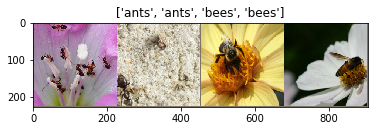

In [7]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# 获取一批训练数据
inputs, classes = next(iter(dataloader['train']))

# 批量制作网格
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 4.训练模型

编写一个通用函数来训练模型。下面将说明：

* 调整学习速率
* 保存最好的模型

下面的参数scheduler是一个来自 torch.optim.lr_scheduler的学习速率调整类的对象(LR scheduler object)。

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    
    best_model_wts = copy.deepcopycopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        for phase in ['train','val']:
            if phase == 'train':
                model.train()
            else :
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs,label in dataloader[phase]:
                inputs = inputs.to(device)
                label = label.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs,1)
                    loss 
                